In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from functools import reduce
import operator

from common_plotting import read_data
from common_analysis import rel_data_cut_index_last, combine_stds_sum, display_full_df
from common_analysis_dcv import (analyse_dcv_absolute, analyse_dcv_relative, analyse_dcv_k182, analyse_dcv_k182_for_other_reference, add_dut_neg_and_pos_group)

plt.rcParams["figure.figsize"] = (10,4)
plt.rc('font', size=14)

# 10 V DC

## 3458A measurements

3458A guard switch was open at all times :)

ACAL DC was done at the beginning of the very first measurement. On the 3458A we used 8.5 digits, NPLC 100. fixed 10V DC range, and triggering 1 reading at a time. Otherwise defaults.

| DUT | Guard connection | DUT power | Number of samples per polarity | Misc comments |
| --- | ---------------- | --------- | ------------------------------ | ------------- |
| LTZ1000-?-branadic | 3458A guard connected to green banana jack (shield) | battery | 16ish | |
| F7001-alm-971756543 | 3458A guard connection follows negative lead of 3458A | mains | 16ish | |
| F7001-bat-alm-971756543 | 3458A guard connection follows negative lead of 3458A | battery |  16ish | |
| V2720GS+10V | 3458A plus/minus connected to plus/minus sense terminals (either polarity). Guard constantly connected to negative output terminal | mains | 16ish | V2720GS set to +10V. Much more samples for one polarity due to us forgetting it |
| V2727GS-10V | 3458A plus/minus connected to plus/minus sense terminals (either polarity). Guard constantly connected to negative output terminal | mains | 16ish | V2720GS set to -10V. |
| 2-LTZ1000-?-branadic | 3458A guard connected to green banana jack (shield) | battery | 32 | Used clean room gloves, waited at least one minute after connecting, stayed at least 2m away from measurement setup |
| 2-F7001-bat-alm-971756543 | 3458A guard connection follows negative lead of 3458A | battery | 32 | Very shortly before 3-LTZ1000-* measurements. Used clean room gloves, waited at least one minute after connecting, stayed at least 2m away from measurement setup |
| 3-LTZ1000-?-branadic | 3458A guard connection follows negative lead of 3458A, and jumper from guard plug to green jack (shield) | battery | 32 | Used clean room gloves, waited at least one minute after connecting, stayed at least 2m away from measurement setup |
| 3a-F7001-bat-alm-971756543 | 3458A guard connection follows negative lead of 3458A | battery | 32 | Used clean room gloves, waited at least one minute after connecting, stayed at least 2m away from measurement setup |

In [68]:
duts = [
'2-F7001-bat-alm-971756543',
'2-LTZ1000-1-branadic',
'2-LTZ1000-2-branadic',
'2-LTZ1000-3-branadic',
'3-LTZ1000-1-branadic',
'3-LTZ1000-2-branadic',
'3-LTZ1000-3-branadic',
'3a-F7001-bat-alm-971756543',
'F7001-alm-971756543',
'F7001-bat-alm-971756543',
'LTZ1000-1-branadic',
'LTZ1000-2-branadic',
'LTZ1000-3-branadic',
'V2720GS+10V',
'V2720GS-10V',
]
data_both_polarities_list = []
summed_up_list = []
for dut in duts:
    data = pd.read_csv(f'MMM2023/12112023_dcv_{dut}.csv', sep=';', parse_dates=['%date-time'])
    data.rename(columns={f' {dut} [V]': 'dut output [V]'}, inplace=True)
    pol_counts = data.groupby(' Polarity (+/-)').agg({'%date-time': ['min', 'count']})
    min_idx = pol_counts[('%date-time', 'count')].idxmin()
    min_count = pol_counts.loc[min_idx][('%date-time', 'count')]
    min_data = data[data[' Polarity (+/-)'] == min_idx]
    if pol_counts.loc[min_idx][('%date-time', 'min')] < pol_counts[pol_counts.index != min_idx][('%date-time', 'min')].min():
        cut_data = data[data[' Polarity (+/-)'] != min_idx].head(min_count)
    else:
        cut_data = data[data[' Polarity (+/-)'] != min_idx].tail(min_count)
    equalized_data = pd.concat([min_data, cut_data])
    equalized_data['dut'] = dut
    data_both_polarities = equalized_data.groupby(['dut', ' Polarity (+/-)']).agg({'dut output [V]': ['mean', 'std', 'sem', 'count'], ' TMP112 [°C]': ['mean'], 'SHT25 [°C]': ['mean'], 'SHT25 [%rH]': ['mean'], 'MS5611 [°C]': ['mean'], 'MS5611 [hPa]': ['mean']})
    data_both_polarities_list.append(data_both_polarities)
    data_to_sum_up = data_both_polarities.reset_index()
    data_to_sum_up['sign_corrected_voltage'] = data_to_sum_up[('dut output [V]', 'mean')] * data_to_sum_up[' Polarity (+/-)'].apply(lambda x: -1 if x == '-' else 1)
    summed_up_data = data_to_sum_up.groupby('dut').agg({('sign_corrected_voltage', ''): ['mean'], ('dut output [V]', 'std'): combine_stds_sum, ('dut output [V]', 'sem'): combine_stds_sum, ('dut output [V]', 'count'): np.sum, (' TMP112 [°C]', 'mean'): ['mean'], ('SHT25 [°C]', 'mean'): ['mean'], ('SHT25 [%rH]', 'mean'): ['mean'], ('MS5611 [°C]', 'mean'): ['mean'], ('MS5611 [hPa]', 'mean'): ['mean']})
    summed_up_list.append(summed_up_data)
data_both_polarities = pd.concat(data_both_polarities_list)
summed_up_data = pd.concat(summed_up_list)
summed_up_data.columns = ['dut output [V] [mean]', 'dut ouptut [V] [std]', 'dut output [V] [sem]', 'dut output [V] [count]', ' TMP112 [°C]', 'SHT25 [°C]', 'SHT25 [%rH]', 'MS5611 [°C]', 'MS5611 [hPa]']
summed_up_data['corrected_output'] = summed_up_data['dut output [V] [mean]'] * 0.999993358
display(data_both_polarities)
display(summed_up_data)

dut output [V]                \
                                                     mean           std   
dut                         Polarity (+/-)                                
2-F7001-bat-alm-971756543  +                     9.999993  2.604091e-07   
                           -                    -9.999994  1.674883e-07   
2-LTZ1000-1-branadic       +                    10.008728  6.013396e-07   
                           -                   -10.008728  2.885776e-07   
2-LTZ1000-2-branadic       +                    10.008836  2.828056e-07   
                           -                   -10.008837  3.276794e-07   
2-LTZ1000-3-branadic       +                     9.989968  4.967027e-07   
                           -                    -9.989970  1.690840e-07   
3-LTZ1000-1-branadic       +                    10.008725  2.435290e-07   
                           -                   -10.008727  1.773597e-07   
3-LTZ1000-2-branadic       +                    10.008837  2.834778e-07   
                           -                   -10.008838  3.211043e-07   
3-LTZ1000-3-branadic       +                     9.989967  1.422851e-07   
                           -                    -9.989970  2.574933e-07   
3a-F7001-bat-alm-971756543 +                     9.999993  1.810384e-07   
                           -                    -9.999995  1.359728e-07   
F7001-alm-971756543        +                     9.999991  1.392824e-07   
                           -                    -9.999992  1.873989e-07   
F7001-bat-alm-971756543    +                     9.999992  1.837015e-07   
                           -                    -9.999993  1.199166e-07   
LTZ1000-1-branadic         +                    10.008723  7.487463e-07   
                           -                   -10.008726  2.253016e-07   
LTZ1000-2-branadic         +                    10.008830  9.045936e-07   
                           -                   -10.008832  2.446145e-07   
LTZ1000-3-branadic         +                     9.989968  1.506652e-07   
                           -                    -9.989970  1.823184e-07   
V2720GS+10V                +                    10.000113  2.821938e-07   
                           -                   -10.000114  2.447550e-07   
V2720GS-10V                +                   -10.000028  4.344455e-07   
                           -                    10.000026  3.096207e-07   

                                                                TMP112 [°C]  \
                                                     sem count         mean   
dut                         Polarity (+/-)                                    
2-F7001-bat-alm-971756543  +                4.603426e-08    32    25.226562   
                           -                2.960802e-08    32    25.107422   
2-LTZ1000-1-branadic       +                1.063028e-07    32    25.277344   
                           -                5.101379e-08    32    25.138672   
2-LTZ1000-2-branadic       +                4.999345e-08    32    25.136719   
                           -                5.792608e-08    32    25.017578   
2-LTZ1000-3-branadic       +                8.780547e-08    32    24.953125   
                           -                2.989012e-08    32    25.160156   
3-LTZ1000-1-branadic       +                4.305024e-08    32    25.226562   
                           -                3.135306e-08    32    25.167969   
3-LTZ1000-2-branadic       +                5.011227e-08    32    25.361328   
                           -                5.676375e-08    32    25.404297   
3-LTZ1000-3-branadic       +                2.515270e-08    32    25.216797   
                           -                4.551882e-08    32    25.384766   
3a-F7001-bat-alm-971756543 +                3.200337e-08    32    25.339844   
                           -                2.403683e-08    32    25.292969   
F7001-alm-971756543        +                3.482060e-08    16    

,dut output [V] [mean],dut ouptut [V] [std],dut output [V] [sem],dut output [V] [count],TMP112 [°C],SHT25 [°C],SHT25 [%rH],MS5611 [°C],MS5611 [hPa],corrected_output
dut,,,,,,,,,,
2-F7001-bat-alm-971756543,9.999994,2.189352e-07,3.870264e-08,64,25.166992,25.116281,33.368906,25.335437,954.877062,9.999927
2-LTZ1000-1-branadic,10.008728,4.716388e-07,8.337475e-08,64,25.208008,25.279453,33.398125,25.455297,955.041906,10.008661
2-LTZ1000-2-branadic,10.008836,3.060660e-07,5.410534e-08,64,25.077148,25.206750,33.521250,25.421312,954.941516,10.008770
2-LTZ1000-3-branadic,9.989969,3.710142e-07,6.558666e-08,64,25.056641,25.100844,33.623750,25.372109,954.886406,9.989902
3-LTZ1000-1-branadic,10.008726,2.130291e-07,3.765858e-08,64,25.197266,25.251766,33.512344,25.449328,955.017719,10.008659
3-LTZ1000-2-branadic,10.008837,3.028759e-07,5.354140e-08,64,25.382812,25.389437,33.560469,25.519781,955.049125,10.008771
3-LTZ1000-3-branadic,9.989968,2.080239e-07,3.677378e-08,64,25.300781,25.284125,33.784219,25.525266,955.113437,9.989902
3a-F7001-bat-alm-971756543,9.999994,1.600992e-07,2.830181e-08,64,25.316406,25.368156,33.947812,25.597031,955.199125,9.999928
F7001-alm-971756543,9.999992,1.651029e-07,4.127572e-08,32,24.992188,25.290719,32.724063,25.497406,955.080969,9.999925


Drift of F7001-alm compared to MM2022 value as calculated based on 3458A measurements and 3458A drift estimated by branadic

In [46]:
(9.999928 - 9.999935) * 1e6 / 10

-0.7000000000090267

## S7081 measurements

Guard from the DMM was always connected to the negative input lead of the DMM at the DUT, and if the DUT had a guard terminal, a banana lead was used between the guard lead from the DMM and the guard terminal on the DUT. MODE=VDC:RANGE=10:NINES=8

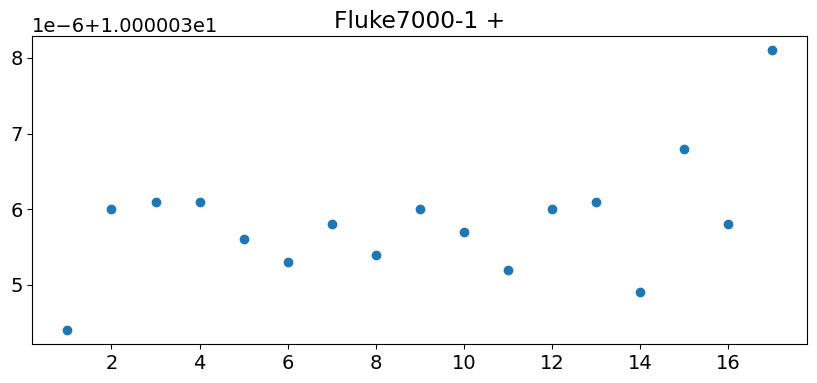

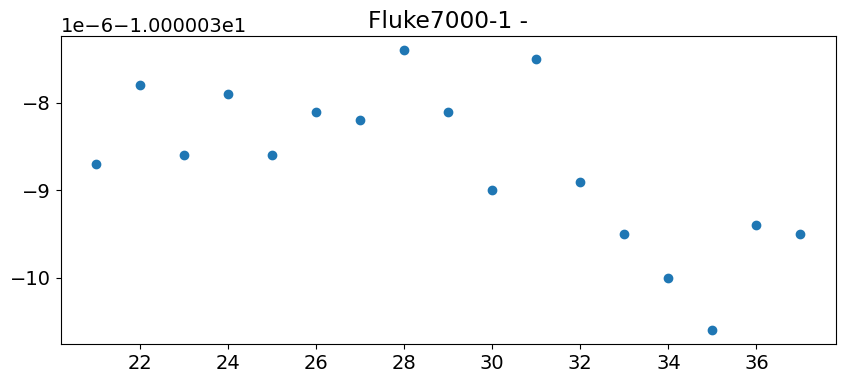

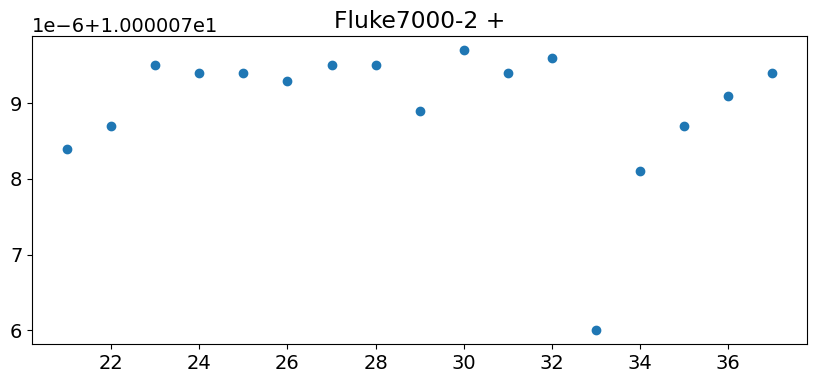

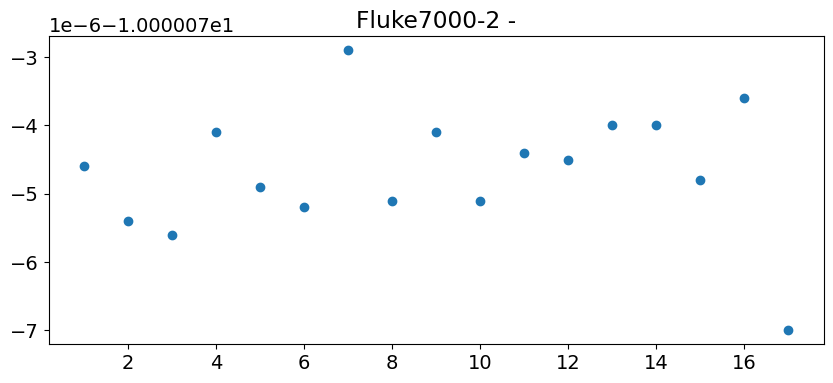

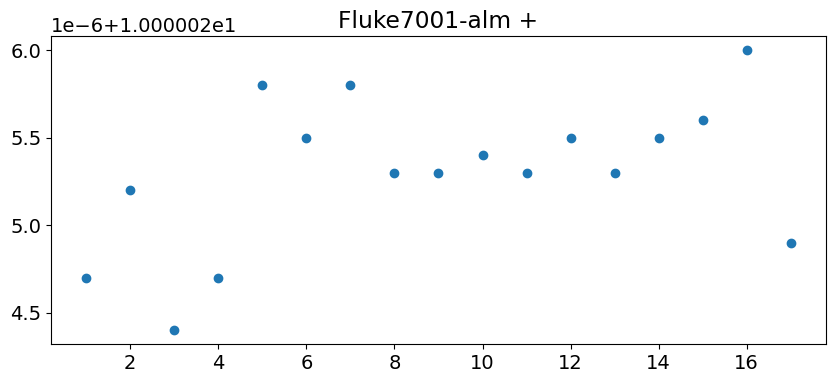

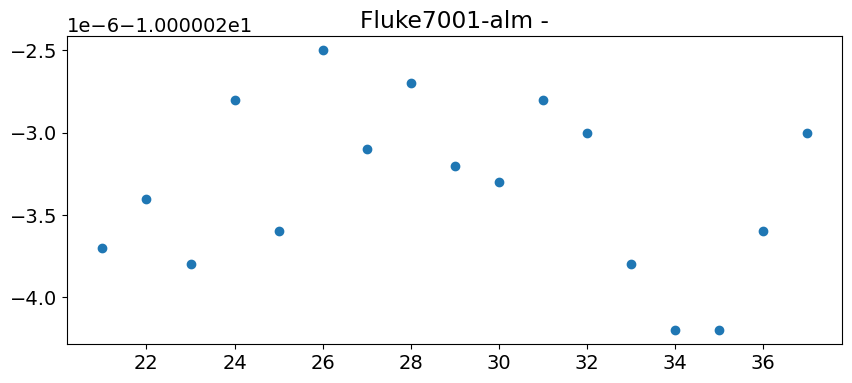

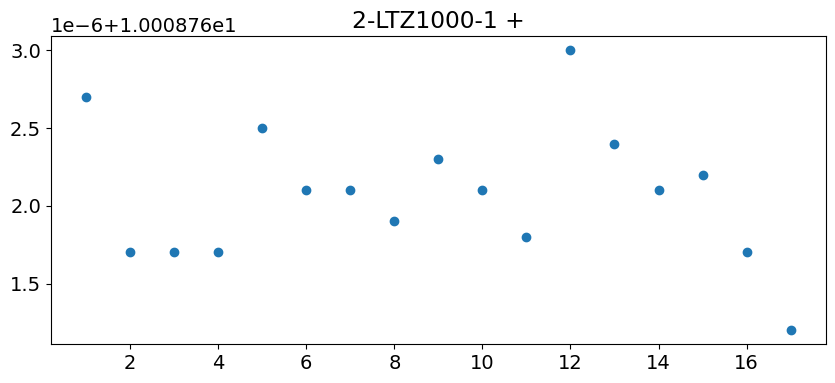

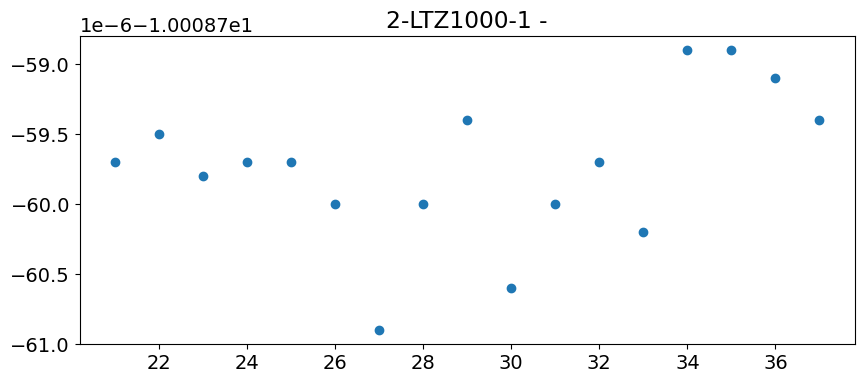

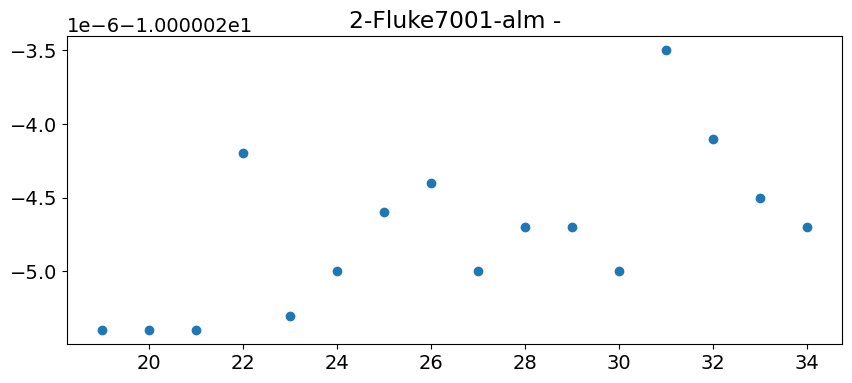

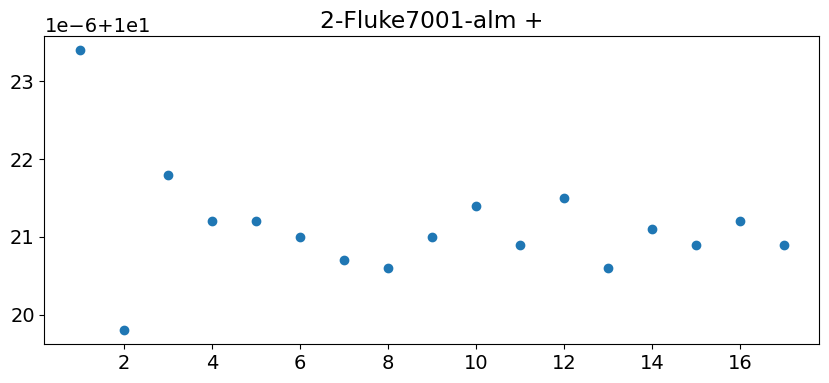

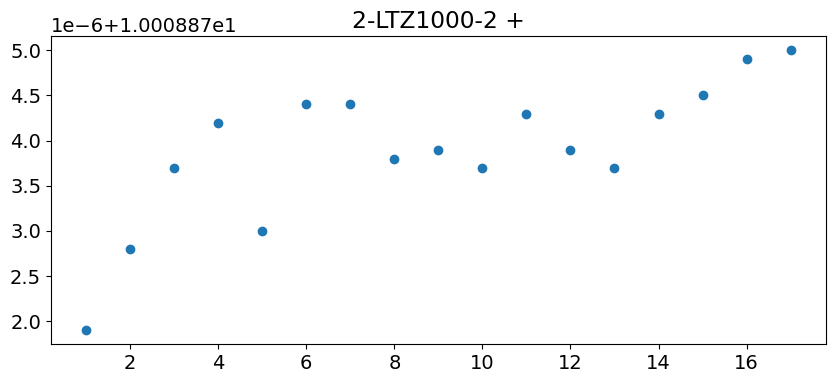

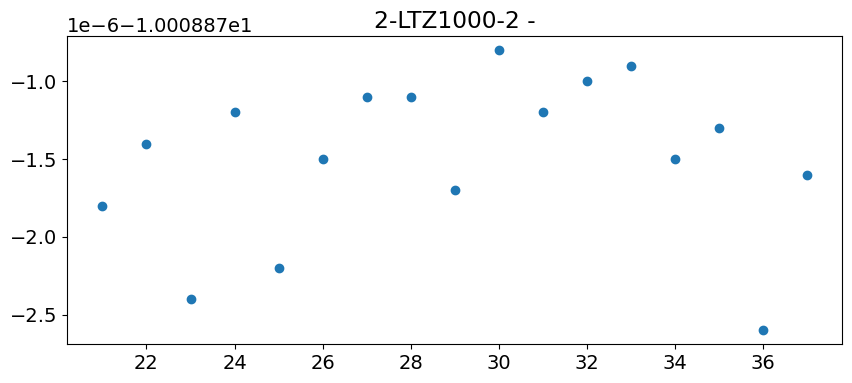

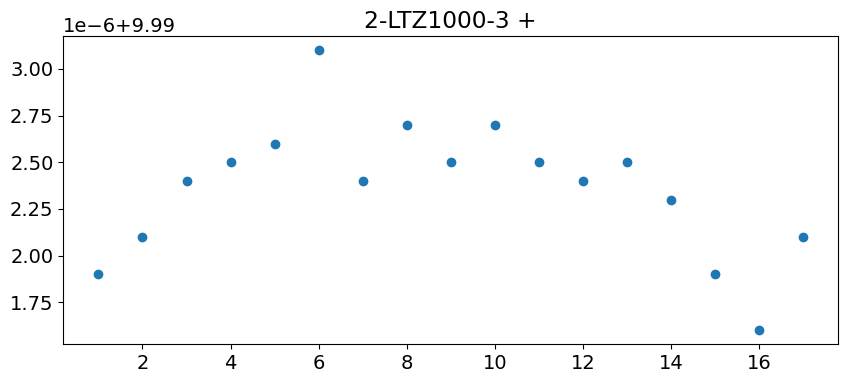

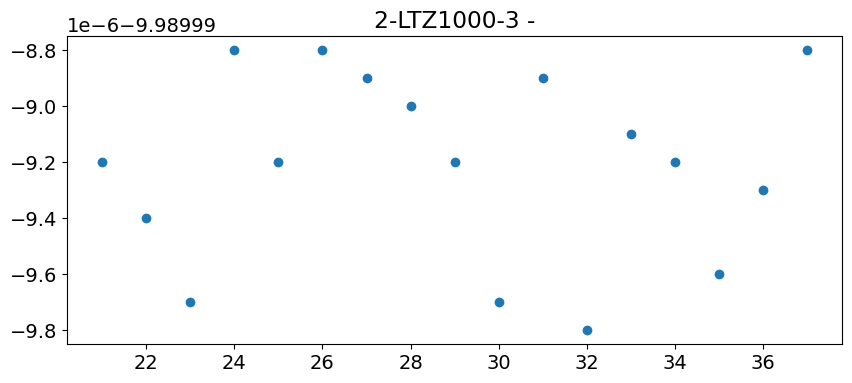

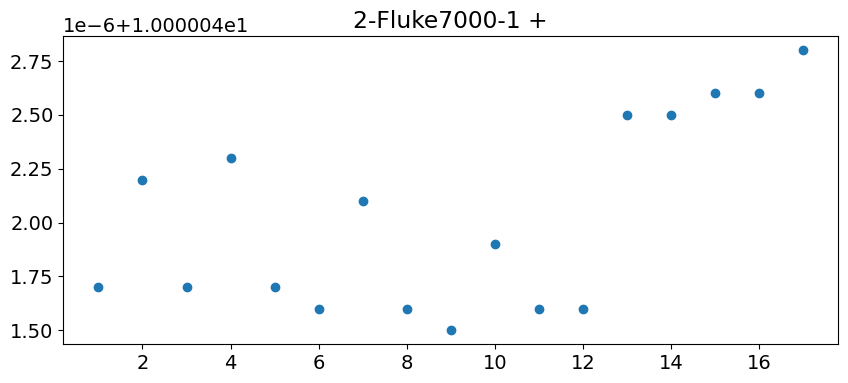

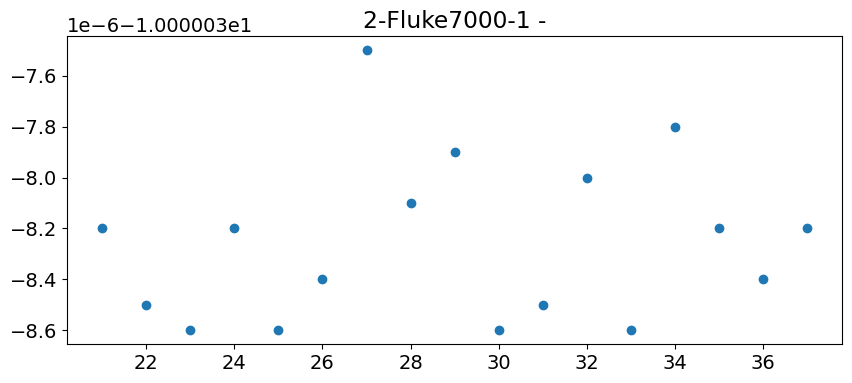

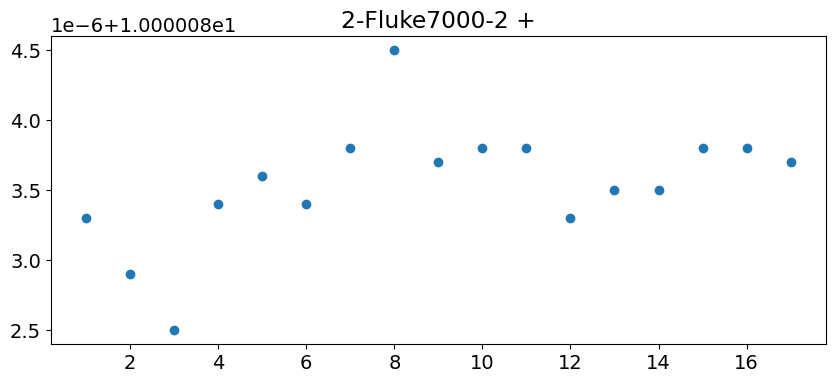

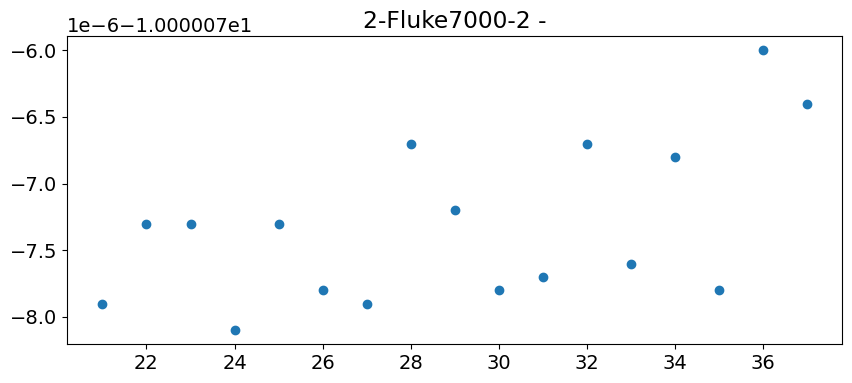

S7081 [V]                                    \
                                      mean           std           sem count   
dut              Polarity (+/-)                                                
Fluke7000-1     +                10.000036  8.000460e-07  1.940396e-07    17   
                -               -10.000039  8.933578e-07  2.166711e-07    17   
Fluke7000-2     +                10.000079  8.905963e-07  2.160013e-07    17   
                -               -10.000075  9.178379e-07  2.226084e-07    17   
Fluke7001-alm   +                10.000025  4.264249e-07  1.034232e-07    17   
                -               -10.000023  5.110543e-07  1.239489e-07    17   
2-LTZ1000-1     +                10.008762  4.355524e-07  1.056370e-07    17   
                -               -10.008760  5.372862e-07  1.303110e-07    17   
2-Fluke7001-alm +                10.000021  7.303806e-07  1.771433e-07    17   
                -               -10.000025  5.328774e-07  1.332194e-07    16   
2-LTZ1000-2     +                10.008874  7.757823e-07  1.881549e-07    17   
                -               -10.008871  5.182692e-07  1.256987e-07    17   
2-LTZ1000-3     +                 9.990002  3.587150e-07  8.700117e-08    17   
                -                -9.989999  3.333211e-07  8.084224e-08    17   
2-Fluke7000-1   +                10.000042  4.440787e-07  1.077049e-07    17   
                -               -10.000038  3.203858e-07  7.770497e-08    17   
2-Fluke7000-2   +                10.000084  4.302872e-07  1.043600e-07    17   
                -               -10.000077  6.040306e-07  1.464989e-07    17   

                                TMP112 [°C] SHT25 [°C] SHT25 [%rH]  \
                                       mean       mean        mean   
dut              Polarity (+/-)                                      
Fluke7000-1     +                 23.238971  23.346294   57.798235   
                -                 23.220588  23.306000   57.841765   
Fluke7000-2     +                 23.275735  23.299059   57.783529   
                -                 23.242647  23.329235   57.740588   
Fluke7001-alm   +                 23.264706  23.263824   57.836471   
                -                 23.272059  23.391235   57.829412   
2-LTZ1000-1     +                 22.838235  22.945059   57.756471   
                -                 22.878676  22.964647   58.102353   
2-Fluke7001-alm +                 23.007353  23.117941   58.242941   
                -                 22.988281  23.105812   58.367500   
2-LTZ1000-2     +                 22.878676  23.040294   58.135882   
                -                 22.882353  23.045412   58.106471   
2-LTZ1000-3     +                 22.882353  23.035235   58.180588   
                -                 22.904412  23.044647   58.259412   
2-Fluke7000-1   +                 22.959559  23.080824   58.135294   
                -                 22.959559  23.077588   58.081176   
2-Fluke7000-2   +                 22.900735  23.014059   58.239412   
                -                 22.878676  22.998176   58.394118   

                                MS5611 [°C] MS5611 [hPa]  
                                       mean         mean  
dut              Polarity (+/-)                           
Fluke7000-1     +                 23.869353   982.445882  
                -                 23.866647   982.316176  
Fluke7000-2     +                 23.841765   981.992882  
                -                 23.869000   982.120412  
Fluke7001-alm   +                 23.878235   982.286000  
                -                 23.901706   982.511235  
2-LTZ1000-1     +                 23.551118   982.419000  
                -                 23.559471   982.044941  
2-Fluke7001-alm +                 23.682000   981.623824  
                -                 23.680875   981.380688  
2-LTZ1000-2     +                 23.627294   980.275529  
                -                 23.624941   980.15576

,dut output [V] [mean],dut ouptut [V] [std],dut output [V] [sem],dut output [V] [count],TMP112 [°C],SHT25 [°C],SHT25 [%rH],MS5611 [°C],MS5611 [hPa]
dut,,,,,,,,,
Fluke7000-1,10.000037,8.479864e-07,2.056669e-07,34,23.229779,23.326147,57.820000,23.868000,982.381029
Fluke7000-2,10.000077,9.043197e-07,2.193297e-07,34,23.259191,23.314147,57.762059,23.855382,982.056647
Fluke7001-alm,10.000024,4.706457e-07,1.141483e-07,34,23.268382,23.327529,57.832941,23.889971,982.398618
2-LTZ1000-1,10.008761,4.890717e-07,1.186173e-07,34,22.858456,22.954853,57.929412,23.555294,982.231971
2-Fluke7001-alm,10.000023,6.393020e-07,1.567277e-07,33,22.997817,23.111877,58.305221,23.681438,981.502256
2-LTZ1000-2,10.008873,6.597125e-07,1.600038e-07,34,22.880515,23.042853,58.121176,23.626118,980.215647
2-LTZ1000-3,9.990001,3.462509e-07,8.397819e-08,34,22.893382,23.039941,58.220000,23.633029,979.575882
2-Fluke7000-1,10.000040,3.872034e-07,9.391062e-08,34,22.959559,23.079206,58.108235,23.645824,979.116941
2-Fluke7000-2,10.000080,5.244044e-07,1.271868e-07,34,22.889706,23.006118,58.316765,23.561265,978.579735


In [92]:
duts_and_filenames = [
('Fluke7000-1', 'MMM2023/12112023_Fluke7000-1_S7081.csv'),
('Fluke7000-2', 'MMM2023/12112023_Fluke7000-2_S7081.csv'),
('Fluke7001-alm', 'MMM2023/12112023_Fluke7001_alm_S7081.csv'),
('2-LTZ1000-1', 'MMM2023/13112023_LTZ1000-1_S7081.csv'),
('2-Fluke7001-alm', 'MMM2023/13112023_F7001_S7081.csv'),
('2-LTZ1000-2', 'MMM2023/13112023_LTZ1000-2_S7081.csv'),
('2-LTZ1000-3', 'MMM2023/13112023_LTZ1000-3_S7081.csv'),
('2-Fluke7000-1', 'MMM2023/13112023_F7000-1_S7081.csv'),
('2-Fluke7000-2', 'MMM2023/13112023_F7000-2_S7081.csv'),
]
data_both_polarities_list = []
summed_up_list = []
for dut, filename in duts_and_filenames:
    data = pd.read_csv(filename, sep=';', parse_dates=['%date-time'])
    data[' Polarity (+/-)'] = data['S7081 [V]'].apply(lambda x: '+' if x > 0 else '-')
    pol_counts = data.groupby(' Polarity (+/-)').agg({'%date-time': ['min', 'count']})
    min_idx = pol_counts[('%date-time', 'count')].idxmin()
    min_data = data[data[' Polarity (+/-)'] == min_idx].iloc[1:18]
    cut_data = data[data[' Polarity (+/-)'] != min_idx].iloc[1:18]
    equalized_data = pd.concat([min_data, cut_data])
    min_data['S7081 [V]'].plot(style="o")
    plt.title(f"{dut} {min_data[' Polarity (+/-)'].iloc[0]}")
    plt.show()
    cut_data['S7081 [V]'].plot(style="o")
    plt.title(f"{dut} {cut_data[' Polarity (+/-)'].iloc[0]}")
    plt.show()
    equalized_data['dut'] = dut
    data_both_polarities = equalized_data.groupby(['dut', ' Polarity (+/-)']).agg({'S7081 [V]': ['mean', 'std', 'sem', 'count'], 'TMP112 [°C]': ['mean'], 'SHT25 [°C]': ['mean'], 'SHT25 [%rH]': ['mean'], 'MS5611 [°C]': ['mean'], 'MS5611 [hPa]': ['mean']})
    data_both_polarities_list.append(data_both_polarities)
    data_to_sum_up = data_both_polarities.reset_index()
    data_to_sum_up['sign_corrected_voltage'] = data_to_sum_up[('S7081 [V]', 'mean')] * data_to_sum_up[' Polarity (+/-)'].apply(lambda x: -1 if x == '-' else 1)
    summed_up_data = data_to_sum_up.groupby('dut').agg({('sign_corrected_voltage', ''): ['mean'], ('S7081 [V]', 'std'): combine_stds_sum, ('S7081 [V]', 'sem'): combine_stds_sum, ('S7081 [V]', 'count'): np.sum, ('TMP112 [°C]', 'mean'): ['mean'], ('SHT25 [°C]', 'mean'): ['mean'], ('SHT25 [%rH]', 'mean'): ['mean'], ('MS5611 [°C]', 'mean'): ['mean'], ('MS5611 [hPa]', 'mean'): ['mean']})
    summed_up_list.append(summed_up_data)
data_both_polarities = pd.concat(data_both_polarities_list)
summed_up_data = pd.concat(summed_up_list)
summed_up_data.columns = ['dut output [V] [mean]', 'dut ouptut [V] [std]', 'dut output [V] [sem]', 'dut output [V] [count]', 'TMP112 [°C]', 'SHT25 [°C]', 'SHT25 [%rH]', 'MS5611 [°C]', 'MS5611 [hPa]']
display(data_both_polarities)
display(summed_up_data)

Offset of S7081 vs corrected value of 3458A (based on F7001-alm measurement)

In [80]:
(10.000024 - 9.999927) / 10 * 1e6

9.700000000023579

## Advantest R6581D measurements

Guard was always floating on DMM side. Guard from the DMM was always connected to the negative input lead of the DMM at the DUT, and if the DUT had a guard terminal, a banana lead was used between the guard lead from the DMM and the guard terminal on the DUT. 100 NPLC, 10V range, 8.5 digit mode.

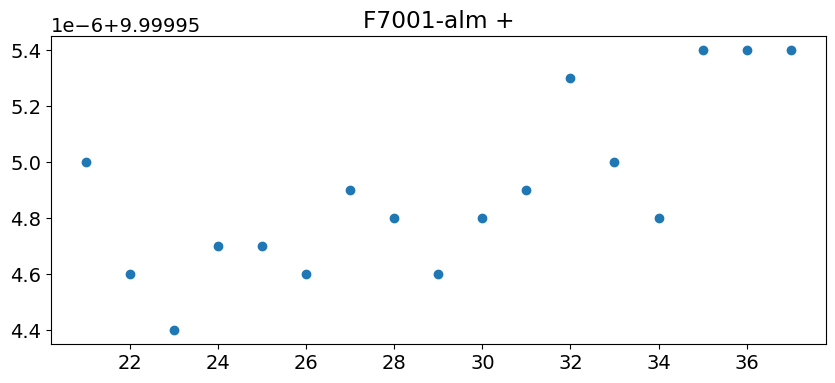

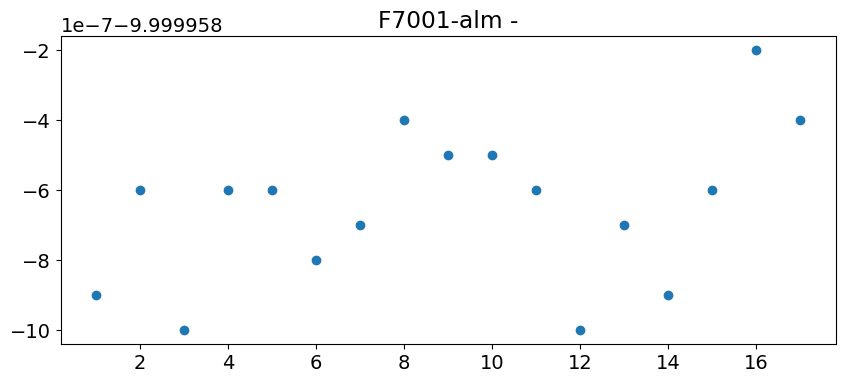

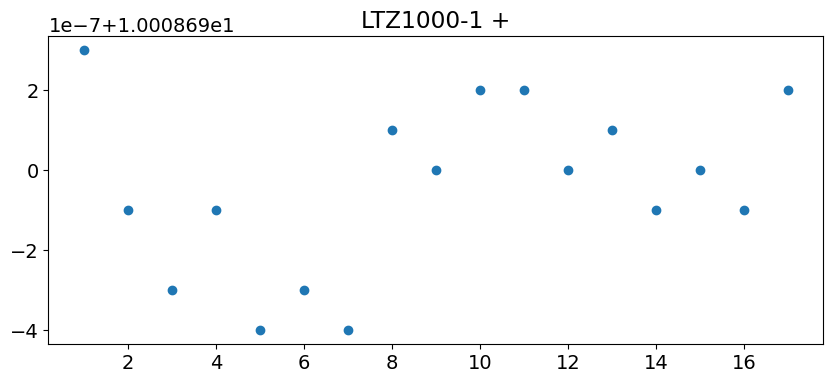

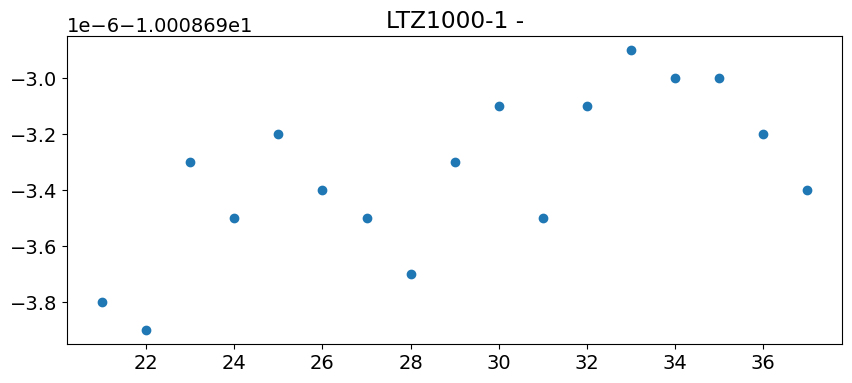

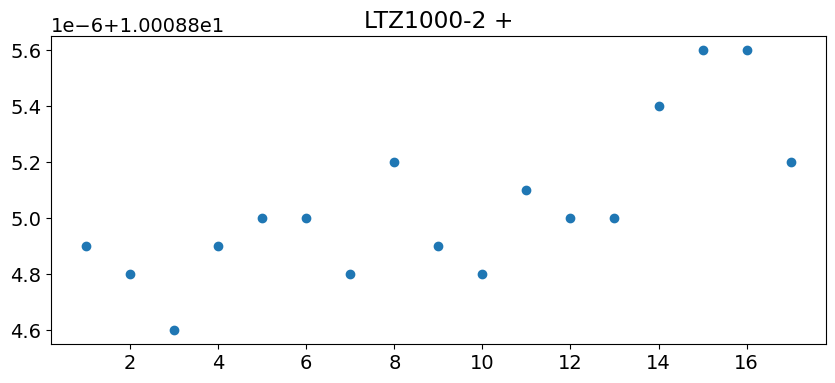

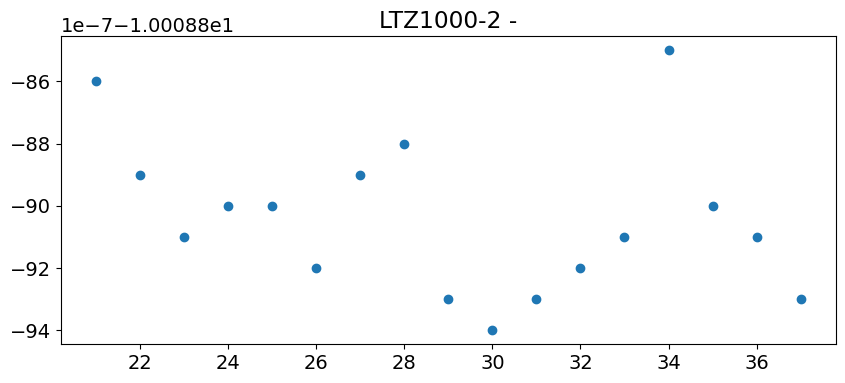

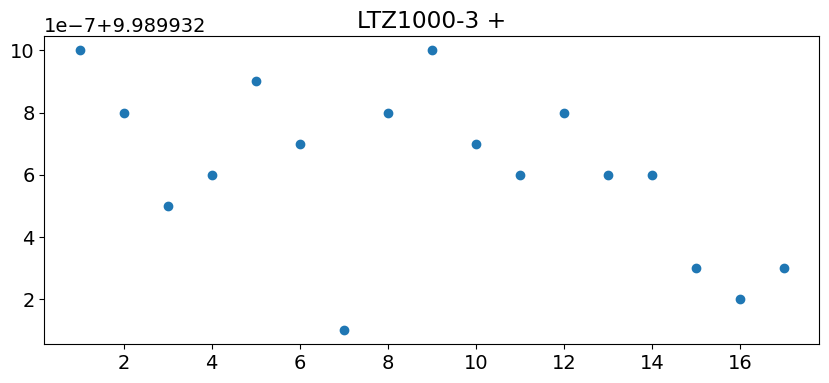

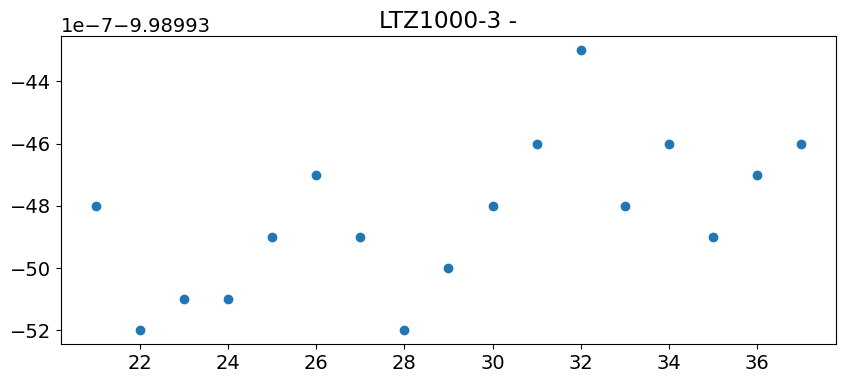

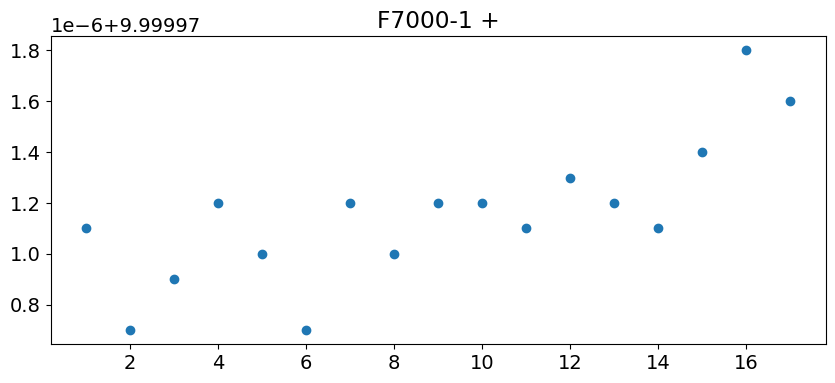

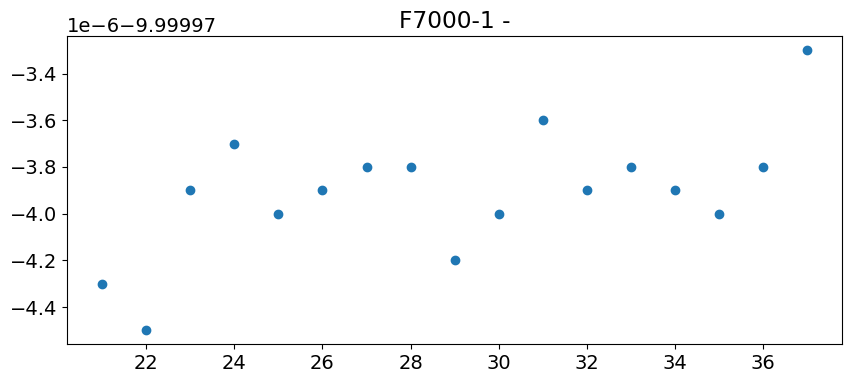

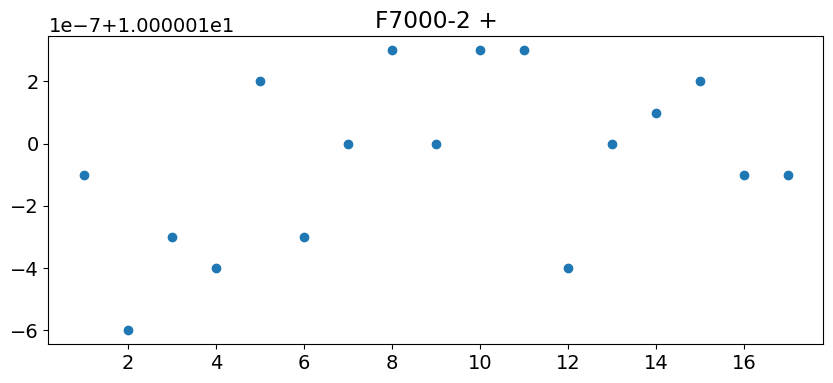

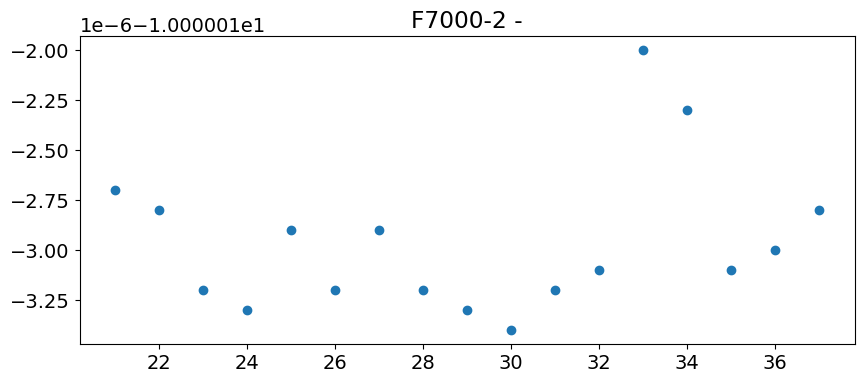

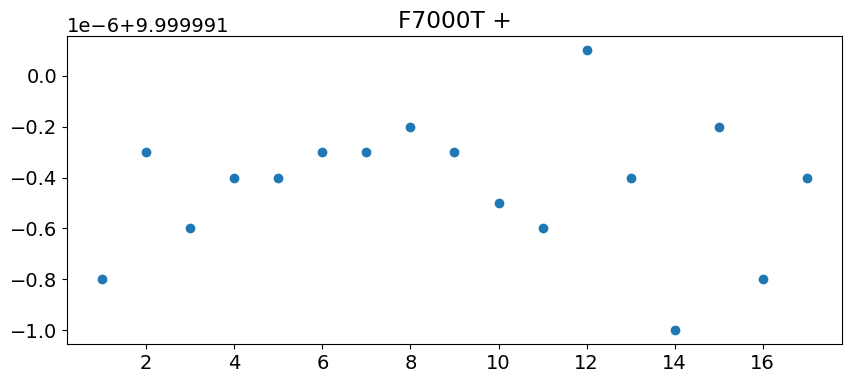

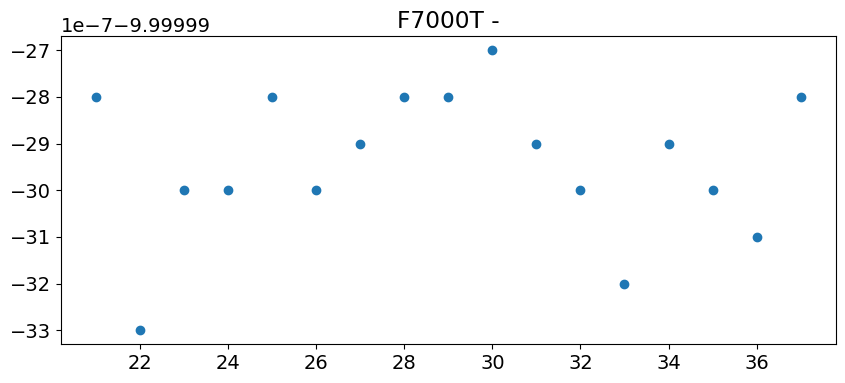

R6581D Front [V]                                    \
                                      mean           std           sem count   
dut        Polarity (+/-)                                                      
F7001-alm +                       9.999955  3.122499e-07  7.573172e-08    17   
          -                      -9.999959  2.211268e-07  5.363113e-08    17   
LTZ1000-1 +                      10.008690  2.152290e-07  5.220070e-08    17   
          -                     -10.008693  2.873561e-07  6.969409e-08    17   
LTZ1000-2 +                      10.008805  2.786522e-07  6.758309e-08    17   
          -                     -10.008809  2.476359e-07  6.006052e-08    17   
LTZ1000-3 +                       9.989933  2.674773e-07  6.487278e-08    17   
          -                      -9.989935  2.422323e-07  5.874995e-08    17   
F7000-1   +                       9.999971  2.785202e-07  6.755108e-08    17   
          -                      -9.999974  2.703484e-07  6.556911e-08    17   
F7000-2   +                      10.000010  2.741296e-07  6.648620e-08    17   
          -                     -10.000013  3.690210e-07  8.950073e-08    17   
F7000T    +                       9.999991  2.644361e-07  6.413518e-08    17   
          -                      -9.999993  1.583462e-07  3.840460e-08    17   

                          TMP112 [°C] SHT25 [°C] SHT25 [%rH] MS5611 [°C]  \
                                 mean       mean        mean        mean   
dut        Polarity (+/-)                                                  
F7001-alm +                 23.095588  23.230353   57.896471   23.688765   
          -                 23.022059  23.125647   58.237647   23.635294   
LTZ1000-1 +                 22.875000  22.989941   58.426471   23.607647   
          -                 22.955882  23.051765   58.505882   23.595941   
LTZ1000-2 +                 23.022059  23.072647   58.487059   23.617647   
          -                 23.014706  23.156529   58.227059   23.647294   
LTZ1000-3 +                 23.106618  23.143294   58.196471   23.664059   
          -                 23.106618  23.189353   58.150000   23.666118   
F7000-1   +                 23.047794  23.177235   58.235882   23.680471   
          -                 23.106618  23.245529   57.996471   23.706941   
F7000-2   +                 23.095588  23.203824   58.060588   23.702059   
          -                 23.088235  23.180471   58.113529   23.716176   
F7000T    +                 22.996324  23.133118   58.244118   23.698294   
          -                 22.948529  23.102235   58.308824   23.671118   

                          MS5611 [hPa]  
                                  mean  
dut        Polarity (+/-)               
F7001-alm +                 981.613529  
          -                 981.618471  
LTZ1000-1 +                 981.071706  
          -                 981.067353  
LTZ1000-2 +                 981.108706  
          -                 981.087765  
LTZ1000-3 +                 981.132824  
          -                 981.098294  
F7000-1   +                 981.033471  
          -                 981.059235  
F7000-2   +                 981.034941  
          -                 980.982647  
F7000T    +                 980.888647  
          -                 980.908824

,dut output [V] [mean],dut ouptut [V] [std],dut output [V] [sem],dut output [V] [count],TMP112 [°C],SHT25 [°C],SHT25 [%rH],MS5611 [°C],MS5611 [hPa]
dut,,,,,,,,,
F7001-alm,9.999957,2.705523e-07,6.561856e-08,34,23.058824,23.178000,58.067059,23.662029,981.616000
LTZ1000-1,10.008692,2.538671e-07,6.157183e-08,34,22.915441,23.020853,58.466176,23.601794,981.069529
LTZ1000-2,10.008807,2.636006e-07,6.393254e-08,34,23.018382,23.114588,58.357059,23.632471,981.098235
LTZ1000-3,9.989934,2.551672e-07,6.188713e-08,34,23.106618,23.166324,58.173235,23.665088,981.115559
F7000-1,9.999973,2.744647e-07,6.656747e-08,34,23.077206,23.211382,58.116176,23.693706,981.046353
F7000-2,10.000011,3.250566e-07,7.883780e-08,34,23.091912,23.192147,58.087059,23.709118,981.008794
F7000T,9.999992,2.179449e-07,5.285941e-08,34,22.972426,23.117676,58.276471,23.684706,980.898735


In [90]:
duts_and_filenames = [
('F7001-alm', 'MMM2023/13112023_F7001_R6581D.csv'),
('LTZ1000-1', 'MMM2023/13112023_LTZ1000-1_R6581D.csv'),
('LTZ1000-2', 'MMM2023/13112023_LTZ1000-2_R6581D.csv'),
('LTZ1000-3', 'MMM2023/13112023_LTZ1000-3_R6581D.csv'),
('F7000-1', 'MMM2023/13112023_F7000-1_R6581D.csv'),
('F7000-2', 'MMM2023/13112023_F7000-2_R6581D.csv'),
('F7000T', 'MMM2023/13112023_F7000T_R6581D.csv'),
]
data_both_polarities_list = []
summed_up_list = []
for dut, filename in duts_and_filenames:
    data = pd.read_csv(filename, sep=';', parse_dates=['%date-time'])
    data[' Polarity (+/-)'] = data['R6581D Front [V]'].apply(lambda x: '+' if x > 0 else '-')
    pol_counts = data.groupby(' Polarity (+/-)').agg({'%date-time': ['min', 'count']})
    min_idx = pol_counts[('%date-time', 'count')].idxmin()
    min_data = data[data[' Polarity (+/-)'] == min_idx].iloc[1:18]
    cut_data = data[data[' Polarity (+/-)'] != min_idx].iloc[1:18]
    equalized_data = pd.concat([min_data, cut_data])
    min_data['R6581D Front [V]'].plot(style="o")
    plt.title(f"{dut} {min_data[' Polarity (+/-)'].iloc[0]}")
    plt.show()
    cut_data['R6581D Front [V]'].plot(style="o")
    plt.title(f"{dut} {cut_data[' Polarity (+/-)'].iloc[0]}")
    plt.show()
    equalized_data['dut'] = dut
    data_both_polarities = equalized_data.groupby(['dut', ' Polarity (+/-)']).agg({'R6581D Front [V]': ['mean', 'std', 'sem', 'count'], 'TMP112 [°C]': ['mean'], 'SHT25 [°C]': ['mean'], 'SHT25 [%rH]': ['mean'], 'MS5611 [°C]': ['mean'], 'MS5611 [hPa]': ['mean']})
    data_both_polarities_list.append(data_both_polarities)
    data_to_sum_up = data_both_polarities.reset_index()
    data_to_sum_up['sign_corrected_voltage'] = data_to_sum_up[('R6581D Front [V]', 'mean')] * data_to_sum_up[' Polarity (+/-)'].apply(lambda x: -1 if x == '-' else 1)
    summed_up_data = data_to_sum_up.groupby('dut').agg({('sign_corrected_voltage', ''): ['mean'], ('R6581D Front [V]', 'std'): combine_stds_sum, ('R6581D Front [V]', 'sem'): combine_stds_sum, ('R6581D Front [V]', 'count'): np.sum, ('TMP112 [°C]', 'mean'): ['mean'], ('SHT25 [°C]', 'mean'): ['mean'], ('SHT25 [%rH]', 'mean'): ['mean'], ('MS5611 [°C]', 'mean'): ['mean'], ('MS5611 [hPa]', 'mean'): ['mean']})
    summed_up_list.append(summed_up_data)
data_both_polarities = pd.concat(data_both_polarities_list)
summed_up_data = pd.concat(summed_up_list)
summed_up_data.columns = ['dut output [V] [mean]', 'dut ouptut [V] [std]', 'dut output [V] [sem]', 'dut output [V] [count]', 'TMP112 [°C]', 'SHT25 [°C]', 'SHT25 [%rH]', 'MS5611 [°C]', 'MS5611 [hPa]']
display(data_both_polarities)
display(summed_up_data)

# Resistance

## S7081 measurements

For every measurement, connected DMM guard wire to negative force terminal on resistor, and banana lead from negative force terminal to guard terminal on resistor.

In [62]:
duts = ['UPW50-104b', 'MI-9331', 'RTU-11k-Resistor-xdevs']
res_data_list = []
for dut in duts:
    res_data = pd.read_csv(f'MMM2023/12112023-{dut}.csv', sep=';', parse_dates=['%date-time'])
    res_data['dut'] = dut
    res_data_list.append(res_data.iloc[-16:])
res_data_s7081 = pd.concat(res_data_list)
grouped_res_data_s7081 = res_data_s7081.groupby('dut').agg({'%date-time': ['mean'], 'S7081 [Ω]': ['mean', 'std', 'sem', 'count'], 'P5017 [Ω]': ['mean', 'std', 'sem', 'count'], 'TMP112 [°C]': 'mean', 'SHT25 [°C]': 'mean', 'SHT25 [%rH]': 'mean', 'MS5611 [°C]': 'mean', 'MS5611 [hPa]': 'mean'})
display(grouped_res_data_s7081)

%date-time  S7081 [Ω]                \
                                                mean       mean           std   
dut                                                                             
MI-9331                2023-11-12 21:14:04.137386752   9.999777  5.977388e-07   
RTU-11k-Resistor-xdevs 2023-11-12 20:33:07.949005824  11.104889  1.243651e-06   
UPW50-104b             2023-11-12 22:18:15.746028800  10.000876  3.930649e-07   

                                               P5017 [Ω]                      \
                                 sem count          mean       std       sem   
dut                                                                            
MI-9331                 1.494347e-07    16  10857.562813  9.623582  2.405896   
RTU-11k-Resistor-xdevs  3.109126e-07    16  10771.349750  4.094112  1.023528   
UPW50-104b              9.826622e-08    16  10804.331062  1.361830  0.340458   

                             TMP112 [°C] SHT25 [°C] SHT25 [%rH] MS5611 [°C]  \
                       count        mean       mean        mean        mean   
dut                                                                           
MI-9331                   16   23.691406  23.756000   56.268750   24.246000   
RTU-11k-Resistor-xdevs    16   23.621094  23.751188   55.945625   24.193188   
UPW50-104b                16   23.722656  23.841812   56.205000   24.281875   

                       MS5611 [hPa]  
                               mean  
dut                                  
MI-9331                  981.790313  
RTU-11k-Resistor-xdevs   981.681312  
UPW50-104b               982.095250

## 3458A measurements

No ACAL OHMS except in the morning at 8am CET. The 3458A was configured with 4-wire resistance, range 10k. OCOMP ON. DELAY 1. 8.5 digits. NPLC 100. Trigger single value. The Keithley 2002, which was used to measure the thermistors branadic built in in every standard resistor, was set up for 4 wire resistance, range 20k, NPLC 50 and offset compensation on.

Guard connections:
* RTU-11k: guard to guard post
* UPW50-104b: guard to guard post
* MI-9331: guard to guard post?
* 2-MI-9331: guard to negative force (C), banana lead (nickel plated brass) from negative force to guard binding post on resistor. Waited at least 5 minutes after changing connections.
* 2-RTU-11k: guard to negative force, banana lead (nickel plated brass) from negative force to guard binding post on resistor. Waited at least 5 minutes after changing connections.
* 2-UPW50-104b: guard to negative force, banana lead (nickel plated brass) from negative force to guard binding post on resistor. Waited at least 5 minutes after changing connections. Put towel over resistor binding posts.

In [63]:
duts = ['MI-9331', 'RTU-11k', 'UPW50-104b', '2-MI-9331', '2-RTU-11k', '2-UPW50-104b']
res_data_list = []
for dut in duts:
    res_data = pd.read_csv(f'MMM2023/12112023_ohmf_{dut}.csv', sep=';', parse_dates=['%date-time'])
    res_data['dut'] = dut
    res_data.rename(columns={f' {dut} [Ohm]': 'dut [Ohm]'}, inplace=True)
    res_data_list.append(res_data.iloc[-16:])
res_data_3458a = pd.concat(res_data_list)
grouped_res_data_3458a = res_data_3458a.groupby('dut').agg({'%date-time': ['mean'], 'dut [Ohm]': ['mean', 'std', 'sem', 'count'],  ' Built-in thermistor [Ohm]': ['mean', 'std', 'sem', 'count'], ' TMP112 [°C]': 'mean', 'SHT25 [°C]': 'mean', 'SHT25 [%rH]': 'mean', 'MS5611 [°C]': 'mean', 'MS5611 [hPa]': 'mean'})
grouped_res_data_3458a['dut_corrected_for_3458a_drift'] = grouped_res_data_3458a[('dut [Ohm]', 'mean')] * 0.99999566
display(grouped_res_data_3458a)

%date-time     dut [Ohm]                      \
                                      mean          mean       std       sem   
dut                                                                            
2-MI-9331    2023-11-12 16:55:00.783951360   9999.815283  0.000755  0.000189   
2-RTU-11k    2023-11-12 17:10:49.928212736  11104.915709  0.001773  0.000443   
2-UPW50-104b 2023-11-12 17:35:51.303903744  10000.898508  0.001412  0.000353   
MI-9331      2023-11-12 14:30:09.840745984   9999.817337  0.000853  0.000213   
RTU-11k      2023-11-12 14:03:34.399069696  11104.928926  0.002165  0.000541   
UPW50-104b   2023-11-12 14:12:40.773735424  10000.918650  0.002151  0.000538   

                    Built-in thermistor [Ohm]                             \
             count                       mean        std       sem count   
dut                                                                        
2-MI-9331       16               10887.274325   9.269232  2.317308    16   
2-RTU-11k       16               10841.069444   6.761109  1.690277    16   
2-UPW50-104b    16               10899.802056   5.405906  1.351477    16   
MI-9331         16               10685.514863   5.126065  1.281516    16   
RTU-11k         16               10648.110463  19.770780  4.942695    16   
UPW50-104b      16               10613.912969  34.192895  8.548224    16   

              TMP112 [°C] SHT25 [°C] SHT25 [%rH] MS5611 [°C] MS5611 [hPa]  \
                     mean       mean        mean        mean         mean   
dut                                                                         
2-MI-9331       25.269531  25.360125   34.224375   25.564438   955.299875   
2-RTU-11k       25.218750  25.211750   34.731875   25.494187   955.499250   
2-UPW50-104b    25.097656  25.105438   34.616875   25.409437   955.673688   
MI-9331         25.089844  25.312500   33.645000   25.555875   955.006750   
RTU-11k         25.117188  25.281625   34.008125   25.440375   954.973000   
UPW50-104b      25.265625  25.309062   33.911875   25.461188   954.860063   

             dut_corrected_for_3458a_drift  
                                            
dut                                         
2-MI-9331                      9999.771883  
2-RTU-11k                     11104.867514  
2-UPW50-104b                  10000.855104  
MI-9331                        9999.773938  
RTU-11k                       11104.880730  
UPW50-104b                    10000.875246

Measured deviation of MI 9331 from nominal by S7081

In [52]:
(10-9.999777)/10 * 1e6

22.300000000008424

Meeasured deviation of MI 9331 from nominal by 3458A (uncorrected)

In [64]:
(10000 - 9999.815283) / 10000 * 1e6

18.47170000000915

Measured deviation of MI 9331 from nominal by 3458A (corrected)

In [65]:
(10000 - 9999.771883) / 10000 * 1e6

22.81170000005659

Estimate of MI 9331 value (with giant uncertainty of > 10 ppm!)

In [53]:
SR104_cal_deviation_1993 = -1.4
deviation_from_cal_mm2022 = -0.44 # uncertainty 10 ppm
deviation_of_MI9331_from_SR104 = -18.7
SR104_cal_deviation_1993 + deviation_from_cal_mm2022 + deviation_of_MI9331_from_SR104

-20.54